In [20]:
import pandas as pd
from tqdm import tqdm

In [21]:
import sys
sys.path.append('../mvTCR/')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

from tcr_embedding.utils_preprocessing import stratified_group_shuffle_split, group_shuffle_split
from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.evaluation.kNN import run_knn_within_set_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function

In [22]:
def load_model(adata, dataset, split, model, donor=''):
    path_model = f'saved_models/journal_2/10x/splits/{model}/10x_donor_{donor}_split_{split}_{model}'
    path_model += '.pt'
    model = utils.load_model(adata, path_model)
    return model
    

In [23]:
from sklearn.preprocessing import OneHotEncoder
def load_10x_data(donor, split):
    adata = utils.load_data('10x')
    if str(donor) != 'None':
        adata = adata[adata.obs['donor'] == f'donor_{donor}']
    else:
        enc = OneHotEncoder(sparse=False)
        enc.fit(adata.obs['donor'].to_numpy().reshape(-1, 1))
        adata.obsm['donor'] = enc.transform(adata.obs['donor'].to_numpy().reshape(-1, 1))
    adata = adata[adata.obs['binding_name'].isin(const.HIGH_COUNT_ANTIGENS)]
    if split != 'full':
        random_seed = split

        train_val, test = group_shuffle_split(adata, group_col='clonotype', val_split=0.20, random_seed=random_seed)
        train, val = group_shuffle_split(train_val, group_col='clonotype', val_split=0.25, random_seed=random_seed)

        adata.obs['set'] = 'train'
        adata.obs.loc[val.obs.index, 'set'] = 'val'
        adata.obs.loc[test.obs.index, 'set'] = 'test'
        adata = adata[adata.obs['set'].isin(['train', 'val', 'test'])]

    return adata

In [24]:
def load_covid_data(split):
    adata = utils.load_data('covid')
    random_seed = split
    sub, non_sub = group_shuffle_split(adata, group_col='clonotype', val_split=0.2, random_seed=random_seed)
    train, val = group_shuffle_split(sub, group_col='clonotype', val_split=0.20, random_seed=random_seed)
    
    adata.obs['set'] = 'train'
    adata.obs.loc[non_sub.obs.index, 'set'] = '-'
    adata.obs.loc[val.obs.index, 'set'] = 'val'
    adata = adata[adata.obs['set'].isin(['train', 'val'])]
    return adata

In [6]:
import numpy as np
for donor in list(range(1, 5)) + ['None']:
    print(f'Donor {donor}:')
    for split in range(5):
        data_tmp = load_10x_data(donor, split)
        n_train = np.sum(data_tmp.obs['set'].values=='train')
        print(f'  Split {split}: {n_train}')

Donor 1:
  Split 0: 5599
  Split 1: 5164
  Split 2: 5756
  Split 3: 6447
  Split 4: 6425
Donor 2:
  Split 0: 18428
  Split 1: 17686
  Split 2: 19046
  Split 3: 17903
  Split 4: 18259
Donor 3:
  Split 0: 12793
  Split 1: 12012
  Split 2: 13428
  Split 3: 12235
  Split 4: 12700
Donor 4:
  Split 0: 3116
  Split 1: 3233
  Split 2: 3165
  Split 3: 3233
  Split 4: 3232
Donor None:
  Split 0: 37323
  Split 1: 37444
  Split 2: 36772
  Split 3: 37352
  Split 4: 38469


In [25]:
dataset = '10x'
donor = 1
metadata = ['binding_name', 'clonotype', 'donor']

model_names = []
splits = []
metrics = []
scores = []
donors = []
for donor in ['None'] + list(range(1, 5)):
    for split in tqdm(range(0, 5)):
        data = load_10x_data(donor, split)
        for model_name in ['concat', 'moe', 'poe', 'tcr', 'rna']:
            model = load_model(data, dataset, split, model_name, donor)
            test_embedding_func = get_model_prediction_function(model)
            for source in ['test']:  #, 'val']:
                summary = run_imputation_evaluation(data, test_embedding_func, query_source=source,
                                            label_pred='binding_name')
                result = summary['knn']['weighted avg']['f1-score']

                model_names.append(model_name)
                splits.append(split)
                metrics.append(f'Prediction {source}')
                scores.append(result)
                donors.append(donor)

            best_nmi = -99
            for resolution in [0.01, 0.1, 1.0]:
                cluster_result = run_clustering_evaluation(data, test_embedding_func, 'train', name_label='binding_name', 
                                                   cluster_params={'resolution': resolution, 'num_neighbors': 5})
                best_nmi = max(cluster_result['NMI'], best_nmi)
            model_names.append(model_name)
            splits.append(split)
            metrics.append('NMI')
            scores.append(best_nmi)  
            donors.append(donor)

results_10x = {
    'model': model_names,
    'split': splits,
    'metric': metrics,
    'score': scores,
    'donor': donors,
    'dataset': [dataset] * len(splits)
}
results_10x = pd.DataFrame(results_10x)
results_10x.to_csv(f'../results/performance_10x.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:59<00:00, 35.90s/it]


In [26]:
results_10x.groupby(['donor', 'metric', 'model'])['score'].mean()

donor  metric           model 
1      NMI              concat    0.562815
                        moe       0.583374
                        poe       0.535455
                        rna       0.474264
                        tcr       0.541161
       Prediction test  concat    0.723679
                        moe       0.817388
                        poe       0.748436
                        rna       0.667646
                        tcr       0.734800
2      NMI              concat    0.389554
                        moe       0.404465
                        poe       0.368788
                        rna       0.364998
                        tcr       0.328578
       Prediction test  concat    0.809158
                        moe       0.836326
                        poe       0.863084
                        rna       0.783740
                        tcr       0.835290
3      NMI              concat    0.005413
                        moe       0.004470
                       

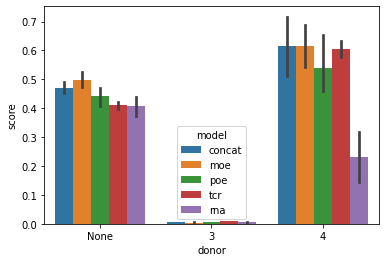

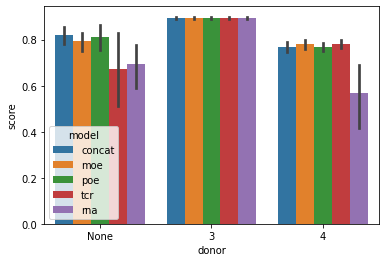

In [28]:
import seaborn as sb
import matplotlib.pyplot as plt
for met in ['NMI', 'Prediction test']:
    res_tmp = results_10x[results_10x['metric']==met]
    res_tmp = res_tmp[res_tmp['donor'].isin([3, 4, 'None'])]
    sb.barplot(data=res_tmp, x='donor', y='score', hue='model')
    plt.show()

In [29]:
results_10x

,model,split,metric,score,donor,dataset
0,concat,0,Prediction test,0.867726,None,10x
1,concat,0,NMI,0.476483,None,10x
2,moe,0,Prediction test,0.845823,None,10x
3,moe,0,NMI,0.528413,None,10x
4,poe,0,Prediction test,0.835327,None,10x
...,...,...,...,...,...,...
245,poe,4,NMI,0.475811,4,10x
246,tcr,4,Prediction test,0.754774,4,10x
247,tcr,4,NMI,0.575606,4,10x
248,rna,4,Prediction test,0.455179,4,10x


In [9]:
raise ValueError

ValueError: 

## Minervina Tests

In [30]:
def load_minervina_model(adata, dataset, split, model):
    path_model = f'saved_models/journal_2/minervina/splits/{model}/'
    path_model += f'minervina_split_{split}_{model}'
    path_model += '.pt'
    model = utils.load_model(adata, path_model)
    return model

In [31]:
from sklearn.preprocessing import OneHotEncoder
def load_minervina_data(split):
    adata = utils.load_data('minervina/01_annotated_data.h5ad')
    # subsample to get statistics
    random_seed = split
    train_val, test = group_shuffle_split(adata, group_col='clonotype', val_split=0.20, random_seed=random_seed)
    train, val = group_shuffle_split(train_val, group_col='clonotype', val_split=0.25, random_seed=random_seed)
    
    adata.obs['set'] = None
    adata.obs.loc[train.obs.index, 'set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'val'
    adata.obs.loc[test.obs.index, 'set'] = 'test'
    return adata

In [32]:
dataset = 'minervina'
metadata = ['epitope']

model_names = []
splits = []
metrics = []
scores = []

for split in tqdm(range(0, 5)):
    data = load_minervina_data(split)
    for model_name in ['concat', 'moe', 'poe', 'tcr', 'rna']:
        model = load_minervina_model(data, dataset, split, model_name)
        test_embedding_func = get_model_prediction_function(model)
        for source in ['test']:  #, 'val']:
            summary = run_imputation_evaluation(data, test_embedding_func, query_source=source,
                                        label_pred='epitope')
            result = summary['knn']['weighted avg']['f1-score']

            model_names.append(model_name)
            splits.append(split)
            metrics.append(f'Prediction {source}')
            scores.append(result)
            donors.append(donor)

        best_nmi = -99
        for resolution in [0.01, 0.1, 1.0]:
            cluster_result = run_clustering_evaluation(data, test_embedding_func, 'train', name_label='epitope', 
                                               cluster_params={'resolution': resolution, 'num_neighbors': 5})
            best_nmi = max(cluster_result['NMI'], best_nmi)
        model_names.append(model_name)
        splits.append(split)
        metrics.append('NMI')
        scores.append(best_nmi)  

results_min = {
    'model': model_names,
    'split': splits,
    'metric': metrics,
    'score': scores,
    'donor': ['-'] * len(splits),
    'dataset': [dataset] * len(splits)
}
results_min = pd.DataFrame(results_min)
results_min.to_csv(f'../results/performance_minervina.csv')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:38<00:00, 43.68s/it]


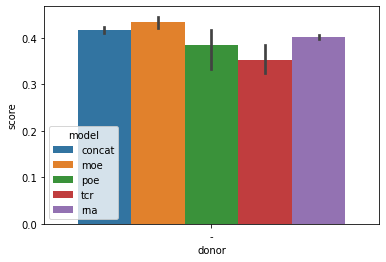

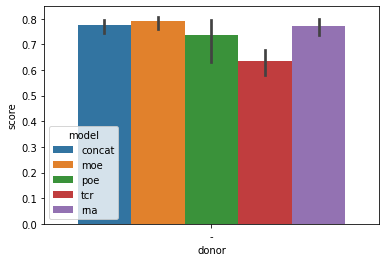

In [33]:
import seaborn as sb
import matplotlib.pyplot as plt
for met in ['NMI', 'Prediction test']:
    res_tmp = results_min[results_min['metric']==met]
    sb.barplot(data=res_tmp, x='donor', y='score', hue='model')
    plt.show()

In [34]:
results_min.groupby(['model', 'metric'])['score'].mean()

model   metric         
concat  NMI                0.416252
        Prediction test    0.775144
moe     NMI                0.433374
        Prediction test    0.789407
poe     NMI                0.385350
        Prediction test    0.736544
rna     NMI                0.401746
        Prediction test    0.770900
tcr     NMI                0.352971
        Prediction test    0.634417
Name: score, dtype: float64

## Dataset size tests

In [7]:
def load_model_size(adata, dataset, split, size, donor=''):
    path_model = f'saved_models/journal_2/10x/data_size/10x_donor_{donor}_split_{split}_moe_{size}'
    path_model += '.pt'
    model = utils.load_model(adata, path_model)
    return model

In [8]:
donor_2_size = {
    'None': [100, 500, 1000, 2500, 5000, 10000, 15000, 30000],
    1: [100, 500, 1000, 2500, 5000],
    2: [100, 500, 1000, 2500,], #5000, 10000, 15000],
    3: [100, 500, 1000, 2500, 5000, 10000],
    4: [100, 500, 1000, 2500],
    'Minervina': [100, 500, 1000, 2500, 5000],
}

In [9]:
dataset = '10x'
metadata = ['binding_name', 'clonotype', 'donor']

sizes = []
splits = []
metrics = []
scores = []
donors = []
for donor in range(1, 3): #['None'] + list(range(1, 5)):
    for split in tqdm(range(0, 5)):
        data = load_10x_data(donor, split)
        for size in donor_2_size[donor]:
            model = load_model_size(data, dataset, split, size, donor)
            test_embedding_func = get_model_prediction_function(model)
            for source in ['test']:  #, 'val']:
                summary = run_imputation_evaluation(data, test_embedding_func, query_source=source,
                                            label_pred='binding_name')
                result = summary['knn']['weighted avg']['f1-score']

                sizes.append(size)
                splits.append(split)
                metrics.append(f'Prediction {source}')
                scores.append(result)
                donors.append(donor)

            best_nmi = -99
            for resolution in [0.01, 0.1, 1.0]:
                cluster_result = run_clustering_evaluation(data, test_embedding_func, 'train', name_label='binding_name', 
                                                   cluster_params={'resolution': resolution, 'num_neighbors': 5})
                best_nmi = max(cluster_result['NMI'], best_nmi)
            sizes.append(size)
            splits.append(split)
            metrics.append('NMI')
            scores.append(best_nmi)  
            donors.append(donor)

results_10x_size = {
    'size': sizes,
    'split': splits,
    'metric': metrics,
    'score': scores,
    'donor': donors
}
results_10x_size = pd.DataFrame(results_10x_size)
results_10x_size.to_csv(f'../results/performance_10x_datasize.csv')

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [16:06<00:00, 193.32s/it]


In [10]:
results_10x_size.groupby(['metric', 'size', 'donor'])['score'].mean()

metric           size  donor
NMI              100   1        0.565510
                       2        0.410771
                 500   1        0.561269
                       2        0.401203
                 1000  1        0.598470
                       2        0.414632
                 2500  1        0.589256
                       2        0.408587
                 5000  1        0.512970
Prediction test  100   1        0.611137
                       2        0.759326
                 500   1        0.794525
                       2        0.771396
                 1000  1        0.751319
                       2        0.743540
                 2500  1        0.743034
                       2        0.822834
                 5000  1        0.800417
Name: score, dtype: float64

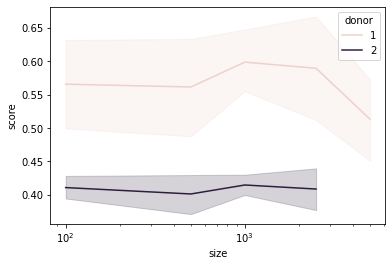

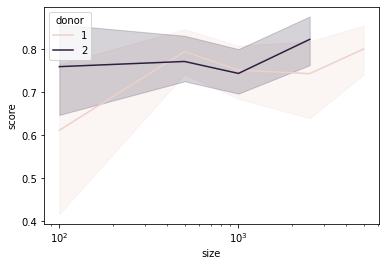

In [11]:
import seaborn as sb
import matplotlib.pyplot as plt
for met in ['NMI', 'Prediction test']:
    sb.lineplot(data=results_10x_size[results_10x_size['metric']==met], x='size', y='score', hue='donor')
    plt.xscale('log')
    plt.show()

## Write Supplemantary Material S1

In [ ]:
raise ValueError

In [ ]:
path_out = '../results/supplement/S1_benchmarking.xlsx'
results_10x.to_excel(path_out, sheet_name='10x')